In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf # ==2.10
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Normalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import autokeras as ak
from imblearn.over_sampling import SMOTE
import optuna
from optuna.samplers import TPESampler
from IPython.display import clear_output
# pip freeze > requirements.txt

d:\Jupiter\AutoML_with_custom_NAS\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pclass — класс пассажира (1 — высший, 2 — средний, 3 — низший);

Name — имя;

Sex — пол;

Age — возраст;

SibSp — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника;

Parch — количество родителей, детей (в том числе приемных) на борту титаника;

Ticket — номер билета;

Fare — плата за проезд;

Cabin — каюта;

Embarked — порт посадки (C — Шербур; Q — Квинстаун; S — Саутгемптон).

In [2]:
data = pd.read_csv('dataset/titanic/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data = data[["Pclass", "Sex", 'Survived','SibSp','Parch', 'Age', 'Fare', 'Embarked']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Survived  891 non-null    int64  
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Age       714 non-null    float64
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [5]:
data.dropna(subset=['Embarked'], inplace=True) #Удаляем пустые данные

#### Кодируем методом OHE колонки Embarked и Sex

In [6]:
data = pd.get_dummies(data, columns=['Embarked', 'Sex', 'Pclass'], drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   SibSp       889 non-null    int64  
 2   Parch       889 non-null    int64  
 3   Age         712 non-null    float64
 4   Fare        889 non-null    float64
 5   Embarked_Q  889 non-null    bool   
 6   Embarked_S  889 non-null    bool   
 7   Sex_male    889 non-null    bool   
 8   Pclass_2    889 non-null    bool   
 9   Pclass_3    889 non-null    bool   
dtypes: bool(5), float64(2), int64(3)
memory usage: 46.0 KB


In [7]:
data.head()

,Survived,SibSp,Parch,Age,Fare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,0,1,0,22.0,7.2500,False,True,True,False,True
1,1,1,0,38.0,71.2833,False,False,False,False,False
2,1,0,0,26.0,7.9250,False,True,False,False,True
3,1,1,0,35.0,53.1000,False,True,False,False,False
4,0,0,0,35.0,8.0500,False,True,True,False,True


##### Заполняем пропуски в колонке Age

In [8]:
print(data['Age'].median())
print(data['Age'].mean())

28.0
29.64209269662921


In [9]:
data.loc[data['Age'].isnull(), 'Age'] = data['Age'].median()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   SibSp       889 non-null    int64  
 2   Parch       889 non-null    int64  
 3   Age         889 non-null    float64
 4   Fare        889 non-null    float64
 5   Embarked_Q  889 non-null    bool   
 6   Embarked_S  889 non-null    bool   
 7   Sex_male    889 non-null    bool   
 8   Pclass_2    889 non-null    bool   
 9   Pclass_3    889 non-null    bool   
dtypes: bool(5), float64(2), int64(3)
memory usage: 46.0 KB


#### Преобразуем данные в необходимый тип

In [10]:
data['Sex_male'] = data['Sex_male'].astype('int8')
data['Survived'] = data['Survived'].astype('int8')

data['Pclass_2'] = data['Pclass_2'].astype('int8')
data['Pclass_3'] = data['Pclass_3'].astype('int8')
data['SibSp'] = data['SibSp'].astype('int8')
data['Parch'] = data['Parch'].astype('int8')

data['Age'] = data['Age'].astype('int8')

data['Embarked_Q'] = data['Embarked_Q'].astype('int8')
data['Embarked_S'] = data['Embarked_S'].astype('int8')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int8   
 1   SibSp       889 non-null    int8   
 2   Parch       889 non-null    int8   
 3   Age         889 non-null    int8   
 4   Fare        889 non-null    float64
 5   Embarked_Q  889 non-null    int8   
 6   Embarked_S  889 non-null    int8   
 7   Sex_male    889 non-null    int8   
 8   Pclass_2    889 non-null    int8   
 9   Pclass_3    889 non-null    int8   
dtypes: float64(1), int8(9)
memory usage: 21.7 KB


In [11]:
data['Embarked_S'].value_counts()

Embarked_S
1    644
0    245
Name: count, dtype: int64

#### Строим гистограммы для каждой колонки

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Embarked_Q'}>],
       [<Axes: title={'center': 'Embarked_S'}>,
        <Axes: title={'center': 'Sex_male'}>,
        <Axes: title={'center': 'Pclass_2'}>],
       [<Axes: title={'center': 'Pclass_3'}>, <Axes: >, <Axes: >]],
      dtype=object)

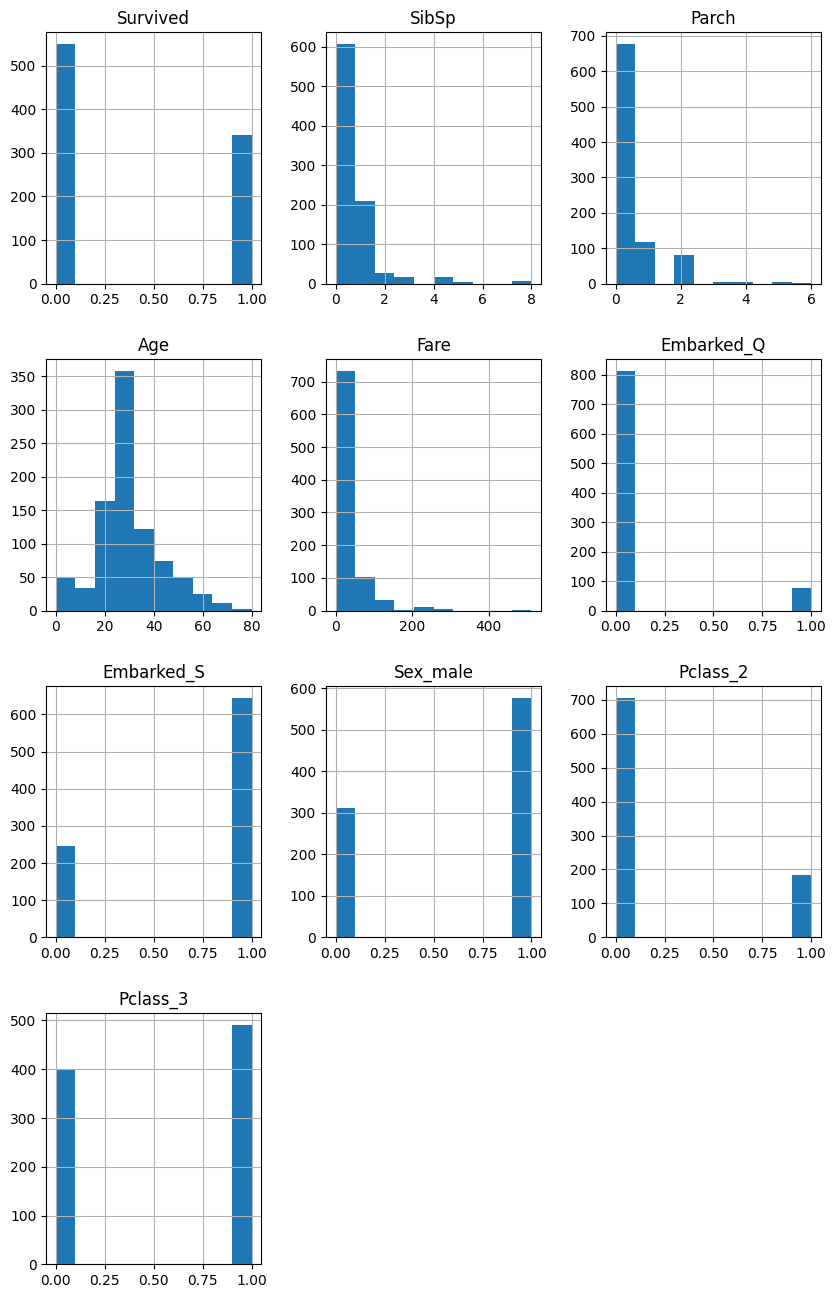

In [12]:
data.hist(figsize=(10,16))

In [13]:
data['Survived'].value_counts() # Дисбаланс классов

Survived
0    549
1    340
Name: count, dtype: int64

In [14]:
features = data.drop(columns=['Survived'])
target = data['Survived']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.15, random_state=12345)

print(features_train.shape)
print(features_test.shape)

(755, 9)
(134, 9)


In [15]:
print(target_train.value_counts())
print(target_test.value_counts())

Survived
0    468
1    287
Name: count, dtype: int64
Survived
0    81
1    53
Name: count, dtype: int64


##### Борьба с дисбалансом классов
Необходимо применить методы борьбы с дисбалансом, чтобы сбалансировать классы

In [16]:
sm = SMOTE(random_state=12345)

features_train_samp, target_train_samp = sm.fit_resample(features_train ,target_train)

target_train_samp.value_counts()

Survived
0    468
1    468
Name: count, dtype: int64

### Тестируем свой собственный алгоритм поиска нейронной архитектуры

In [17]:
def visuall (history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+ metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+ metric, 'val_'+ metric])
    plt.show()

In [18]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
from AutoML import TabularDataClassifier

tdc = TabularDataClassifier(n_trails=5, n_class=2)

tdc.fit(features_train_samp, target_train_samp, verbose = 2, batch_size = 8, epochs = 1000, 
    validation_data=(features_test, target_test))



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 32)                320       
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 normalization_13 (Normaliza  (None, 32)               65        
 tion)                                                           
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 normalization_14 (Normaliza  (None, 16)               33        
 tion)                                                

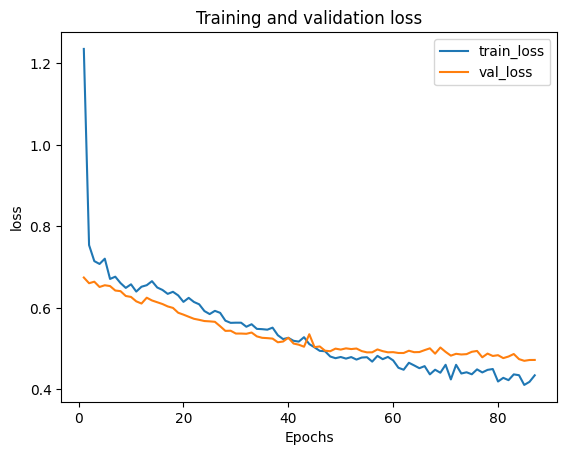

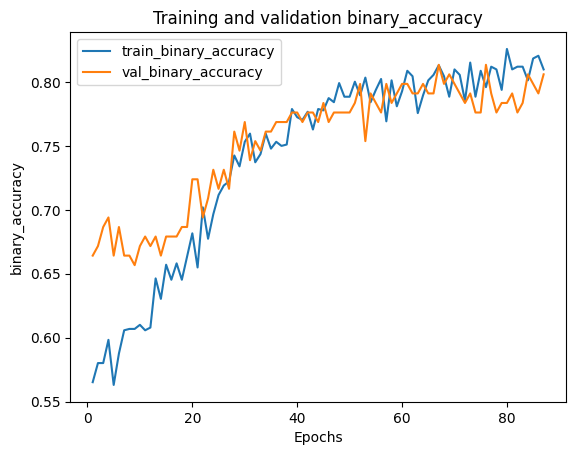

In [21]:
#from AutoML import TabularDataClassifier
#tdc = TabularDataClassifier(n_trails=5)
history = tdc.history

visuall(history, 'loss')
visuall(history, 'binary_accuracy')


### Ссылки на источники
<ul>
    <li>
        <a href="https://keras.io/api/layers/preprocessing_layers/numerical/normalization/">Слой нормализации</a> 
    </li>
    <li>
        <a href="https://keras.io/guides/writing_your_own_callbacks/">Custom Callback</a> 
    </li>
    <li>
        <a href="https://keras.io/keras_tuner/">Keras Tuner</a> 
    </li>
    <li>
        <a href="https://autokeras.com">AutoKeras</a> 
    </li>
    <li>
        <a href="https://autokeras.com/structured_data_classifier/">AutoKeras Classification</a> 
    </li>
    <li>
        <a href="https://habr.com/ru/articles/704432/">HUBR optuna</a> 
    </li>
    <li>
        <a href="https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler">Optuna TRE Sampler</a> 
    </li>
    <li>
        <a href="https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_int">Optuna Trail</a> 
    </li>
    <li>
        <a href=""></a> 
    </li>
    <li>
        <a href=""></a> 
    </li>
</ul>